## 1) Import modules

In [2]:
import pickle
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import pprint
pp = pprint.PrettyPrinter()

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## 2) Read the data

#### Read the FED indicators & understand the structure

In [4]:
fed_indcs_wmt_rps = pd.read_csv('../data/fed_wmt_data_final.csv',parse_dates=True,index_col='fillingDate')
fed_indcs_wmt_rps.shape

(86, 963)

In [5]:
fed_indcs_wmt_rps.head()

,1,3,5,6,7,9,11,14,16,19,...,1229_lag1,1238_lag1,1240_lag1,1243_lag1,1244_lag1,1253_lag1,revenuePerShare_lag1,revenuePerShare_lag2,revenuePerShare_lag3,revenuePerShare_lag4
fillingDate,,,,,,,,,,,,,,,,,,,,,
2000-04-30,-0.41,0.014810,-0.177778,-0.100601,6.02,0.028571,0.025400,-0.001065,0.17,0.002994,...,5.3,90.1,89.5,90.1,90.1,-31.8,2.454245,2.217499,2.168347,2.066177
2000-07-31,-0.29,0.008757,0.135135,0.010017,6.54,-0.006700,0.031022,-0.020343,-0.09,0.008955,...,4.2,90.1,89.3,90.1,90.1,-10.8,2.277066,2.454245,2.217499,2.168347
2000-10-31,-0.17,0.006944,-0.142857,-0.051240,6.51,0.016758,0.018974,-0.009612,-0.55,-0.010355,...,5.7,95.3,94.5,95.3,95.3,-7.2,2.345074,2.277066,2.454245,2.217499
2001-01-31,0.40,0.006322,0.305556,-0.101045,5.98,0.025670,0.013785,0.007508,-0.13,-0.001495,...,5.1,94.6,93.8,94.6,94.6,9.3,2.335628,2.345074,2.277066,2.454245
2001-04-30,0.91,0.010280,-0.106383,-0.003876,4.80,0.039168,0.018624,0.023900,1.17,-0.001497,...,6.1,99.1,98.1,99.1,99.1,-31.1,2.546824,2.335628,2.345074,2.277066


## 3) Separate X & Y Variables

In [6]:
x_train = fed_indcs_wmt_rps.drop('revenuePerShare',axis=1).copy()
y_train = fed_indcs_wmt_rps['revenuePerShare'].copy()

### 4) Scale X & Y Variables

In [7]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

In [8]:
y_scaler = StandardScaler()
y_train_scaled = y_train.copy()
y_train_scaled = pd.DataFrame(y_scaler.fit_transform(pd.DataFrame(y_train_scaled)),
                              index = y_train.index,columns=[y_train.name])
y_train_scaled = y_train_scaled['revenuePerShare']
y_train_scaled

fillingDate
2000-04-30   -2.182955
2000-07-31   -2.036617
2000-10-31   -2.056943
2001-01-31   -1.602495
2001-04-30   -1.950078
                ...   
2020-07-31    1.275669
2020-10-31    1.226983
2021-01-31    1.487973
2021-04-30    1.297479
2021-07-31    1.351925
Name: revenuePerShare, Length: 86, dtype: float64

### 5) Build basic linear regression

In [9]:
clf = linear_model.LinearRegression()
clf.fit(x_train_scaled, y_train_scaled)
coeffs = pd.Series(clf.coef_,index=x_train.columns)
coeffs

1                      -0.012670
3                      -0.001269
5                       0.001719
6                       0.002008
7                      -0.006706
                          ...   
1253_lag1               0.003912
revenuePerShare_lag1    0.028847
revenuePerShare_lag2    0.029087
revenuePerShare_lag3    0.028957
revenuePerShare_lag4    0.029562
Length: 962, dtype: float64

In [10]:
(abs(coeffs) > 0).sum()

962

### 6) Basic Lasso Regression

In [11]:
clf = linear_model.Lasso(alpha=0.0001)
clf.fit(x_train_scaled, y_train_scaled)
coeffs = pd.Series(clf.coef_,index=x_train.columns)
coeffs

/Users/mahendra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-02, tolerance: 8.600e-03
  model = cd_fast.enet_coordinate_descent(


1                      -0.000000
3                      -0.018121
5                       0.000000
6                       0.000000
7                      -0.408867
                          ...   
1253_lag1               0.000000
revenuePerShare_lag1    0.000000
revenuePerShare_lag2    0.000000
revenuePerShare_lag3    0.000000
revenuePerShare_lag4    0.005501
Length: 962, dtype: float64

In [12]:
(abs(coeffs) > 0).sum()

165

### 7) Choosing alpha such that we have <=20 vars with coefficients

In [13]:
alphathresh = 0.01
train = True
while train:
  clf = linear_model.Lasso(alpha=alphathresh,max_iter = 1000000)
  clf.fit(x_train_scaled,y_train_scaled)
  coeffs = pd.Series(clf.coef_,index=x_train.columns)
  if (abs(coeffs)>0).sum() <= 25:
    train = False
  else:
    alphathresh = alphathresh*2
coeffs = coeffs[abs(coeffs)>0]
print(len(coeffs))
coeffs


22


84                     -0.001274
102                     0.006562
133                    -0.007981
391                    -0.008150
453                    -0.000135
1316                    0.009238
1360                    0.006277
327                    -0.009570
529                     0.001478
1061                   -0.007107
1436                   -0.002283
494                    -0.004155
752                    -0.007043
1237                   -0.005436
223_lag1                0.000787
915_lag1                0.016552
1360_lag1               0.007343
1259_lag1               0.124149
1240_lag1               0.006717
revenuePerShare_lag1    0.020567
revenuePerShare_lag2    0.053951
revenuePerShare_lag4    0.760102
dtype: float64

### 8) Get the y preds and inverse scale and inverse transform the preds and actual values

In [14]:
y_train_preds = pd.DataFrame(clf.predict(x_train_scaled),index = y_train.index,columns = ['revenuePerShare'])
y_train_preds = pd.DataFrame(y_scaler.inverse_transform(y_train_preds),index= y_train.index,columns = ['revenuePerShare'])
y_train_preds = y_train_preds['revenuePerShare']

y_train_preds = np.exp(y_train_preds)
y_train = np.exp(y_train)
y_train


fillingDate
2000-04-30     9.748037
2000-07-31    10.434043
2000-10-31    10.335944
2001-01-31    12.766495
2001-04-30    10.862223
                ...    
2020-07-31    48.637712
2020-10-31    47.549594
2021-01-31    53.681257
2021-04-30    49.133215
2021-07-31    50.392283
Name: revenuePerShare, Length: 86, dtype: float64

### 9) Get the error metrics

In [15]:
r2 = r2_score(y_train, y_train_preds)
r2 = round(r2, 4)

mape = mean_absolute_percentage_error(y_train, y_train_preds)
mape = round(mape*100, 2)

f'{r2} {mape}'

'0.9979 1.39'

### 10) Plot the actuals and preds

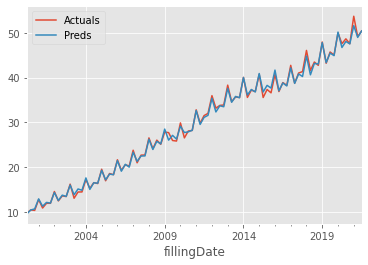

In [16]:
actual_preds = pd.concat([y_train,y_train_preds],axis=1)
actual_preds.columns = ['Actuals', 'Preds']
actual_preds.plot()
plt.show()

### 11) Read the FED Indcs description

In [3]:
fed_indcs = pd.read_csv('../data/fed_description.csv')
fed_indcs.columns = ['id', 'title']
fed_indcs.shape

(1462, 2)

### 12) Map the name of the indicators to coefficients

In [18]:
remove_lag_string = lambda x: re.sub(r'_lag.*$', '', str(x))

def get_fed_details(coeffs_list):
  result = map(remove_lag_string, coeffs_list)
  return fed_indcs.loc[fed_indcs['id'].astype('str').isin(result),:]

coeff_details = get_fed_details(list(dict(coeffs).keys()))

coeff_details

,id,title
84,84,China / U.S. Foreign Exchange Rate
102,102,Global price of Sunflower Oil
133,133,Population
223,223,Cass Freight Index: Shipments
327,327,"Consumer Loans, All Commercial Banks"
391,391,S&P/Case-Shiller MA-Boston Home Price Index
453,453,S&P/Case-Shiller DC-Washington Home Price Index
494,494,Real Estate Loans: Residential Real Estate Loa...
529,529,"Producer Price Index by Commodity: Pulp, Paper..."
752,752,M1 for Japan
